# 📕Fine-tuning a pre-trained machine translation model

Machine translation has come a long way in recent years, and pre-trained models such as those based on transformer architectures have shown impressive performance on a wide range of translation tasks. However, to achieve the best results for a specific use case, it is often necessary to fine-tune the model on domain-specific data. 

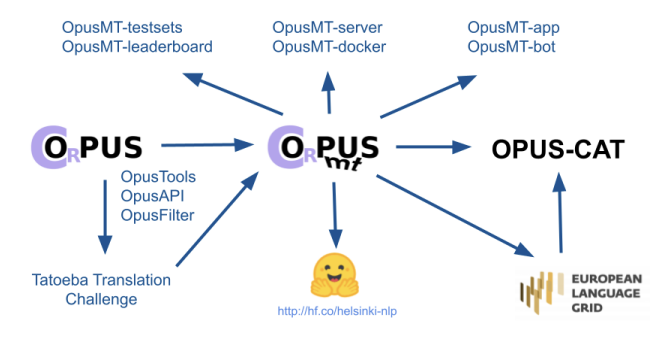

## Introduction

In this tutorial, you will learn how to fine-tune a pre-trained model for a machine translation task. It will walk you through the following steps:

-  📑 Download the dataset and put it in the argilla space.
- 👣 Preprocess the dataset for the fine-tuning. 
- 📈 Fine-tune the dataset into the model and train it. 
- 📊 Evaluate the model.

Let's get started!

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:

1. [Deploy Argilla on Hugging Face Spaces](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla): This is the fastest option and the recommended choice for connecting to external notebooks (e.g., Google Colab) if you have an account on Hugging Face.

2. [Launch Argilla using Argilla's quickstart Docker image](../../getting_started/quickstart.ipynb): This is the recommended option if you want Argilla running on your local machine. Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip
    
This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or on a Jupyter notebook tool of your choice.
</div>

## Setup

For this tutorial, you'll need to install the Argilla client and a few third party libraries using `pip`:

In [ ]:
!pip install argilla 

Let's import the Argilla module for reading and writing data:

In [ ]:
import argilla as rg

If you are running Argilla using the Docker quickstart image or Hugging Face Spaces, you need to init the Argilla client with the `URL` and `API_KEY`:

In [ ]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
rg.init(
    api_url="https://mariav-mariav-argilla.hf.space", 
    api_key="team.apikey"
)

Finally, let's include the imports we need:

In [ ]:
!pip install datasets openai
!pip install transformers
!pip install sacrebleu
!pip install evaluate
!pip install sentencepiece #to use the tokenizer

import os
import openai 

openai.api_key = os.getenv("OPENAI_API_KEY") 

from argilla import Text2TextRecord

import pandas as pd

from sklearn.model_selection import train_test_split

from datasets import Dataset
from datasets import load_dataset

from transformers import AutoTokenizer

from transformers import TFAutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq

from transformers import create_optimizer
from transformers.keras_callbacks import PushToHubCallback
import tensorflow as tf

import evaluate

import numpy as np
from tqdm import tqdm

## ⏬ Download the dataset

We're going to be using the [wmt16](https://huggingface.co/datasets/wmt16/viewer/de-en/train) dataset, available in Hugging Face for the translation from German to English, but it can also be used for other language pairs. 

The dataset has no annotation, which is fine, because that's not really compulsory for a machine translation task. 

Let's download our dataset using:

```
from datasets import load_dataset 
dataset= load_dataset('datasetname')
```

And adding the parameters that the dataset needs. In this case, the language pairs: 'de-en', and the specification of the split we want. 

In [ ]:
train_dataset = load_dataset("wmt16",'de-en', split='train[1:10000]')

We only need the train split for this part of the code, but it's possible to download the validation and test splits just by changing the names in the split part. (Check [Hugging Face](https://huggingface.co/docs/datasets/loading) for more information about loading datasets)

As the dataset is too big, we can just select the number of examples we want to keep by selecting a range:


```
split='train[1:10000]'
```

In this case, we're going to be keeping from 1 to 10.000 examples. Depending on the quality of the performance you want to get, you can select a different number.

We can also check how our data looks like by selecting an example of the dataset:

In [ ]:
train_dataset['translation'][1]

In case you are working with data that contains more columns and you don't want to use them, don't worry 😊, you can simply remove them by: 

`dataset = dataset.remove_columns("column name, column name")`

Now, we begging with the loading of our dataset into our Hugging Face Argilla space. The first thing we need to do is select what will be going into our dataset and how.

As we want our dataset to be for a machine translation task, we have to prepare it with [Text2Text](https://docs.argilla.io/en/latest/guides/how_to.html#3.-Text2Text):


```
def extract (row):
  return {"text": row["translation"]["de"], "annotation": row["translation"]["en"]}

dataset_for_training=train_dataset.map(extract)
```

In this way, we're selecting our german sentences as input (called text in argilla) and the english sentences as target (called annotation).

If you want to keep just the german sentences or the english ones, then you can select only the according row. 


In [ ]:
def extract(row):
    return {"text": row["translation"]["de"], "annotation": row["translation"]["en"]}

dataset_for_training=train_dataset.map(extract)

In [ ]:
# Read Dataset into an Argilla Dataset
dataset_rg = rg.read_datasets(dataset_for_training, task="Text2Text")

In [ ]:
rg.log(dataset_rg, "wmt16-for-translation")

With this done, we should have in our Argilla Space all the sentences with the german ones as input along with the corresponding translation in english. It should look like this: 

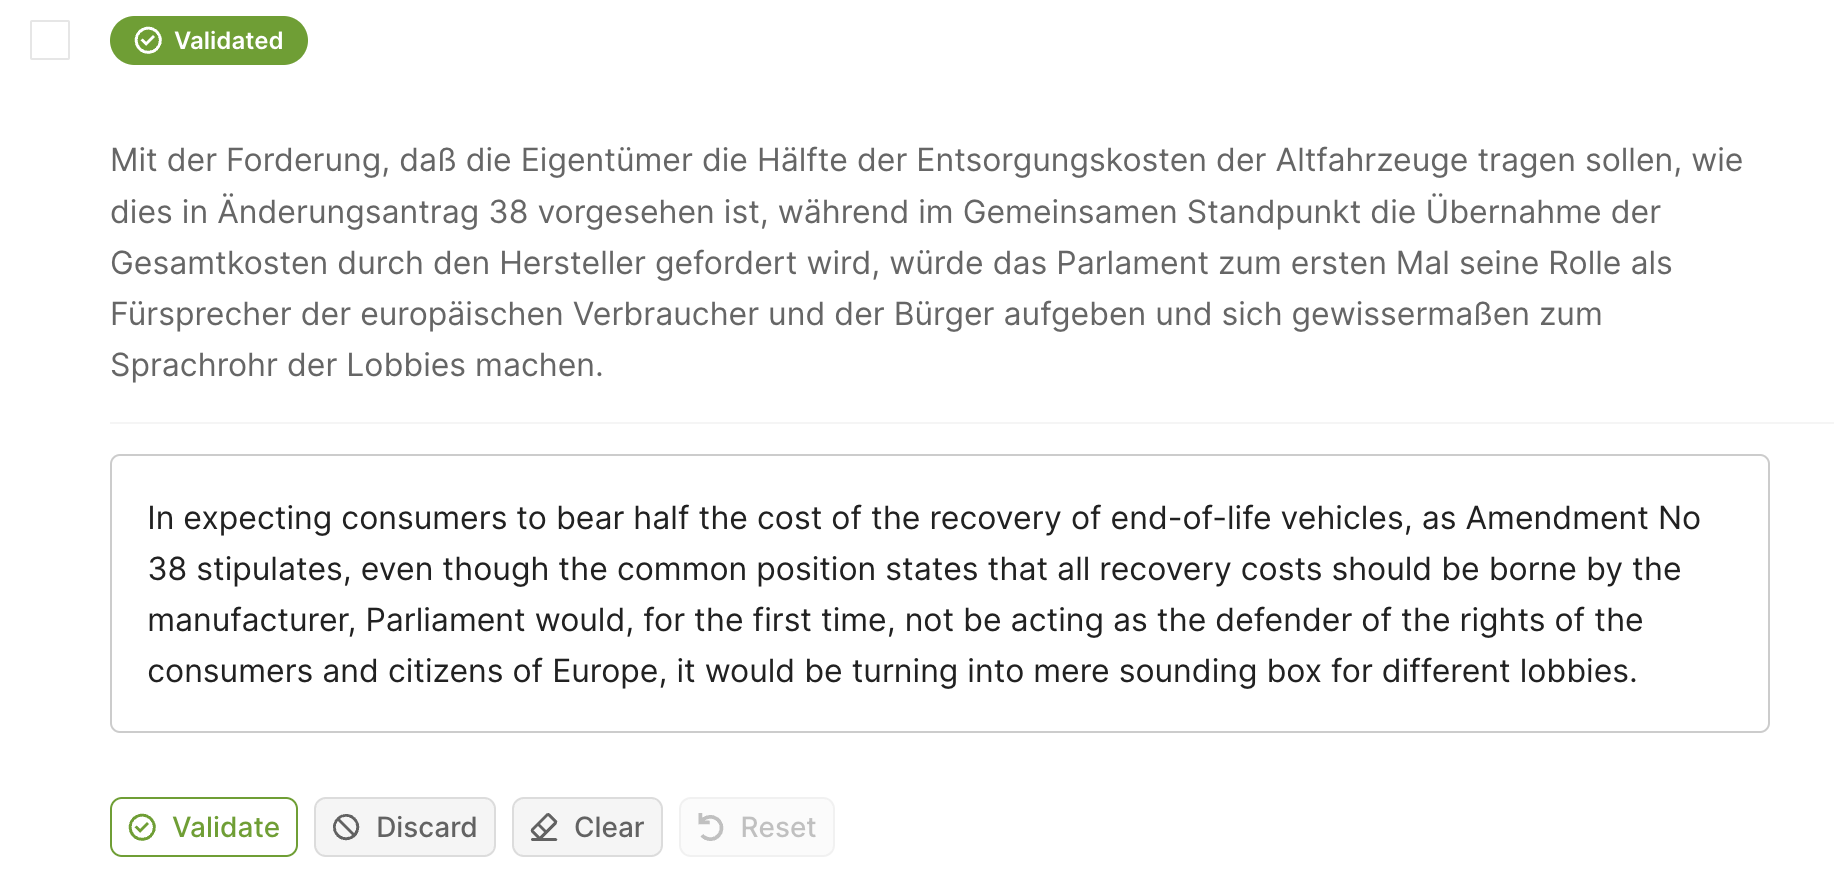

Now, we have the possibility to check the translations, make possible changes and even annotate (if necessary) before performing our task. ✌

## 🔽 Preprocess the dataset 

The first thing we need to do is to call our dataset, with the `rg.load().to_datasets()` function. 

In [ ]:
training_data = rg.load("wmt16-for-translation").to_datasets()

To make sure that we have all the information that we need, we can see an example of the dataset with `training_data[1]`

In [ ]:
training_data[1]



---


We will follow the next steps:
- Convert the dataset to a pandas dataframe.
- Split the dataset into train and validation sets.
- Import the tokenizer: in this case, we will be using the same model as for fine-tuning ([Helsinki-NLP/opus-mt-de-en](https://huggingface.co/Helsinki-NLP/opus-mt-de-en))
- Tokenize the train and validation datasets.



---



💪 Let's start preparing everything:



In [ ]:
#convert the dataset to a pandas dataframe.
df = pd.DataFrame(training_data)

If you want, you can check how the dataset looks like by using `df.head()`, just to consider if there's any type of error.

We split the dataset into training and validation sets and we also check how our data looks like:

In [ ]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_df.iloc[0]

Now that we have the dataset splitted, we can convert them into datasets (because it's easier to work with this type of data for the fine-tuning) just by applying `Dataset` function to our current pandas datasets:

In [ ]:
# convert train and validation dataframes to datasets
train_dataset = Dataset.from_pandas(train_df)
validation_dataset = Dataset.from_pandas(val_df)

In [ ]:
#As always, we check the data 
train_dataset[1]

We import the Tokenizer we're going to be using with the `AutoTokenizer` from Transformers:

In [ ]:
model_checkpoint = "Helsinki-NLP/opus-mt-de-en"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

Next, we define the preprocess function:

- We set the `max_length` to 128 to avoid issues such as memory errors, slow processing times, and poor model performance.

- We define as inputs the examples we have in the 'text' column (german sentences) and as targets the examples from the 'annotation' column (english sentences):

In [ ]:
max_length = 128


def preprocess_function(examples):
    inputs = examples['text']
    targets = examples['annotation']
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True
    )
    return model_inputs

Finally, we apply the tokenizer to both training and validation sets. This shall not take long 🕛

In [ ]:
tokenized_train_dataset = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_dataset.column_names,
)

tokenized_val_dataset = validation_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=validation_dataset.column_names,
)

And we check if it actually worked and we have what we desire:

In [ ]:
tokenized_train_dataset[0]

As we can see, the output shows the `inputs_ids`, `attention_mask` and `labels`. If not, this may mean that there is an error in your preprocessing function that can later affect the training part.

## 😰 Prepare the training

In this section, we're going to create a simple training using the same model provided for the tokenizer ([Helsinki-NLP/opus-mt-de-en](https://huggingface.co/Helsinki-NLP/opus-mt-de-en)).

In order to download it we will use the `TFAutoModelForSeq2SeqLM` from the transformers library, with the `from_pt` set to `True`, because if not the model will give an error advise. This way, the library will automatically download and convert the PyTorch weights.

In [ ]:
model = TFAutoModelForSeq2SeqLM.from_pretrained('Helsinki-NLP/opus-mt-de-en', from_pt=True)

We create a simple datacollator, calling the `DataCollatorForSeq2Seq` from `Transformers` and prepare the datasets for the training part:

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

In [ ]:
tf_train_dataset = model.prepare_tf_dataset(
    tokenized_train_dataset,
    collate_fn=data_collator,
    shuffle=True,
    batch_size=32,
)
tf_eval_dataset = model.prepare_tf_dataset(
    tokenized_val_dataset,
    collate_fn=data_collator,
    shuffle=False,
    batch_size=16,
)

Now, we can download into our Hugging Face account to save our model here later. 

In case you don't want to be using Hugging Face, you can skip this part.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

We define the parameters of our training and we're going to use `mixed_float16`, which helps with speeding the training using GPU.

As you can see, the number of epochs is set to 5. This amount of epochs, which seems to be really low, already takes a lot of time to process 😩, so you can try first with 3 epochs just to check if the model works and then increase it. 

In [ ]:
num_epochs = 5
num_train_steps = len(tf_train_dataset) * num_epochs

optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(optimizer=optimizer)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

We call the PushToHubCallback to have our model in the Hugging Face repository. In case you don't want to share it in Hugging Face you can change the `output_dir` to your own computer or to your drive.

In [ ]:
from transformers.keras_callbacks import PushToHubCallback

callback = PushToHubCallback(
    output_dir="helsinki-opus-de-en-fine-tuned-wmt16", tokenizer=tokenizer
)

model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    callbacks=[callback],
    epochs=num_epochs,
)

## 💪 Let's evaluate our model

We can check how good is the performance of our model using this metric: Bleu Score, which is a common metric for machine translation models. 

For that, first we download the metric using `evaluate.load()` and then we create a function that will take our validation dataset (that we prepared earlier for training) and check the performance of the model with the Blue metric. This may take a long time ⏳ because of the `batch_size` selected earlier, so we can just change it to 8 to speed up the process. 

In [ ]:
#import the metric
metric = evaluate.load("sacrebleu")

In [ ]:
generation_data_collator = DataCollatorForSeq2Seq(
    tokenizer, model=model, return_tensors="tf", pad_to_multiple_of=128
)

tf_eval_dataset = model.prepare_tf_dataset(
    tokenized_val_dataset,
    collate_fn=data_collator,
    shuffle=False,
    batch_size=8,
)

def generate(batch):
    return model.generate(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        max_new_tokens=128,
    )

def compute_metrics():
    all_preds = []
    all_labels = []

    for batch, labels in tqdm(tf_eval_dataset):
        predictions = generate(batch)
        decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
        labels = labels.numpy()
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        decoded_preds = [pred.strip() for pred in decoded_preds]
        decoded_labels = [[label.strip()] for label in decoded_labels]
        all_preds.extend(decoded_preds)
        all_labels.extend(decoded_labels)

    result = metric.compute(predictions=all_preds, references=all_labels)
    return {"bleu": result["score"]}

In [ ]:
print(compute_metrics())

## Summary

In this tutorial we've learned how to fine-tune a pre-trained machine learning model with our own dataset. Now we're capable of:
- 🖊 Using argilla as a resource to improve our dataset in an easy way, 
- ⏫  loading the dataset and prepare it for training, 
- 📈 performing a training with TensorFlow keras, 
- 📊 and finally evaluating our model with the Bleu score.

Through fine-tuning we allow the model to adapt to the specific language used in a particular domain or task, and improve the fluency and accuracy of the translated text. 👏